## 1. Interploate the missing dates.

The following dates are missing in the dataset:



In [1]:
import pandas as pd

# Load the CSV file
basin_id = "05535070"
file_path = f'c:/Users/ybrot/Desktop/course/UROP/GAGEii_modeling/US_climate_discharge_data/{basin_id}.csv'
df = pd.read_csv(file_path)
df.rename(columns={"Date": "date"}, inplace=True)

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Generate a date range from the minimum to the maximum date in the dataframe
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex the dataframe to this date range
df_reindexed = df.reindex(date_range)

# Find missing dates
missing_dates = df_reindexed[df_reindexed.isnull().any(axis=1)].index

# Print missing dates
print("Missing dates:")
for date in missing_dates:
    print(date.strftime('%Y-%m-%d'))

# Check frequency
frequency = pd.infer_freq(df.index)
print(f"Detected frequency: {frequency}")

Missing dates:
1980-12-31
1984-12-31
1988-12-31
1992-12-31
1996-12-31
2000-12-31
2004-12-31
2008-12-31
2012-12-31
2016-12-31
2020-12-31
Detected frequency: None


Therefore, we will interpolate the missing dates in the dataset.

In [2]:
import os
import pandas as pd
from tqdm import tqdm

# Define the input and output folders
input_folder = 'US_climate_discharge_data'
output_folder = 'data/csv_files'
missing_dates_file = 'c:/Users/ybrot/Desktop/course/UROP/GAGEii_modeling/basin_list/US_full_basin_list.txt'

# Read the list of basin IDs
with open(missing_dates_file, 'r') as file:
    basin_ids = file.read().splitlines()

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Function to interpolate missing dates
def interpolate_missing_dates(df, missing_dates):
    # Ensure the 'date' column is in datetime format
    df.rename(columns={"Date": "date"}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    # Set the 'date' column as the index
    df.set_index('date', inplace=True)
    # Generate a complete date range from the minimum to the maximum date in the dataframe
    date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    # Reindex the dataframe to this date range
    df_reindexed = df.reindex(date_range)
    # Interpolate missing values
    df_interpolated = df_reindexed.interpolate(method='time')
    return df_interpolated

# Process each CSV file
for basin_id in tqdm(basin_ids):
    input_file = os.path.join(input_folder, f'{basin_id}.csv')
    output_file = os.path.join(output_folder, f'{basin_id}.csv')
    
    # Read the CSV file
    df = pd.read_csv(input_file)
    
    # Interpolate missing dates
    missing_dates = [
        '1980-12-31', '1984-12-31', '1988-12-31', '1992-12-31', 
        '1996-12-31', '2000-12-31', '2004-12-31', '2008-12-31', 
        '2012-12-31', '2016-12-31', '2020-12-31'
    ]
    df_interpolated = interpolate_missing_dates(df, missing_dates)
    
    # Reset the index to have 'date' as a column again
    df_interpolated.reset_index(inplace=True)
    df_interpolated.rename(columns={'index': 'date'}, inplace=True)
    
    # Write the output CSV file
    df_interpolated.to_csv(output_file, index=False)

print("Interpolation and file writing completed.")

100%|██████████| 130/130 [00:10<00:00, 12.60it/s]

Interpolation and file writing completed.


In [3]:
import os
import pandas as pd
from tqdm import tqdm

# Define the input and output folders
input_folder = 'Canadian_climate_discharge_data'
output_folder = 'data/csv_files'
missing_dates_file = 'c:/Users/ybrot/Desktop/course/UROP/GAGEii_modeling/basin_list/Canada_full_basin_list.txt'

# Read the list of basin IDs
with open(missing_dates_file, 'r') as file:
    basin_ids = file.read().splitlines()

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Function to interpolate missing dates
def interpolate_missing_dates(df, missing_dates):
    # Ensure the 'date' column is in datetime format
    df.rename(columns={"Date": "date"}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    # Set the 'date' column as the index
    df.set_index('date', inplace=True)
    # Generate a complete date range from the minimum to the maximum date in the dataframe
    date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    # Reindex the dataframe to this date range
    df_reindexed = df.reindex(date_range)
    # Interpolate missing values
    df_interpolated = df_reindexed.interpolate(method='time')
    return df_interpolated

# Process each CSV file
for basin_id in tqdm(basin_ids):
    input_file = os.path.join(input_folder, f'{basin_id}.csv')
    output_file = os.path.join(output_folder, f'{basin_id}.csv')
    
    # Read the CSV file
    df = pd.read_csv(input_file)
    
    # Interpolate missing dates
    missing_dates = [
        '1980-12-31', '1984-12-31', '1988-12-31', '1992-12-31', 
        '1996-12-31', '2000-12-31', '2004-12-31', '2008-12-31', 
        '2012-12-31', '2016-12-31', '2020-12-31'
    ]
    df_interpolated = interpolate_missing_dates(df, missing_dates)
    
    # Reset the index to have 'date' as a column again
    df_interpolated.reset_index(inplace=True)
    df_interpolated.rename(columns={'index': 'date'}, inplace=True)
    
    # Write the output CSV file
    df_interpolated.to_csv(output_file, index=False)

print("Interpolation and file writing completed.")

100%|██████████| 79/79 [00:06<00:00, 12.52it/s]

Interpolation and file writing completed.


## 2. Check the data for missing dates.

In [6]:
import os
import pandas as pd

# Define the directory containing the imputed CSV files
directory = 'data/csv_files'

# Initialize a flag to check if all files meet the condition
all_files_valid = True
non_satisfying_files = []

# Get the list of all file names in the directory
basin_ids = [f.split('.')[0] for f in os.listdir(directory) if f.endswith('.csv')]

# Iterate over each file in the directory
for basin_id in tqdm(basin_ids):
    
    file_path = f'data/csv_files/{basin_id}.csv'
    file_name = f'{basin_id}.csv'
        
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    df.rename(columns={"Date": "date"}, inplace=True)
    # Ensure the 'date' column is in datetime format and set as index
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.set_index('date', inplace=True)
    
    # Create a full date range and check for missing dates
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    missing_dates = full_range.difference(df.index)
    
    # Check if the frequency of missing dates is 'D'
    if missing_dates.freq != 'D':
        # print(f"File {file_name} does not meet the condition.")
        # print(f"Frequency of missing dates: {missing_dates.freq}")
        all_files_valid = False
        non_satisfying_files.append(file_name)
        

if all_files_valid:
    print("All files meet the condition.")
else:
    print("Some files do not meet the condition.")

100%|██████████| 209/209 [00:03<00:00, 56.80it/s]

All files meet the condition.


## 3. Convert the data to a time series. (NetCDF)

In [9]:
from file_conversion import DataFrame_to_CDF
from tqdm import tqdm
import pandas as pd


output_path = 'c:/Users/ybrot/Desktop/course/UROP/GAGEii_modeling/data/time_series'

for basin_id in tqdm(basin_ids):
    # Construct the file path for the CSV file
    csv_file_path = f'data/csv_files/{basin_id}.csv'
    
    # Read the CSV file into a DataFrame
    
    df = pd.read_csv(csv_file_path, index_col='date')
    df.index = pd.to_datetime(df.index)
    
    if df.isnull().values.any():
        print(f"Skipping basin {basin_id} due to missing values")
        print(f"number of missing values: {df.isnull().sum().sum()}")
        print(f"rows with missing values: {df[df.isnull().any(axis=1)].index}")
        print(f"columns with missing values: {df.columns[df.isnull().any()]}")
        raise ValueError("Missing values found in the DataFrame")
    
    # Convert the DataFrame to a CDF file
    DataFrame_to_CDF(df, output_path, basin_id)
    

100%|██████████| 209/209 [00:05<00:00, 34.99it/s]


## 4. Model Training

In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

In [2]:
start_run(config_file=Path('config.yml'))

2025-02-04 11:03:50,073: Logging to c:\Users\ybrot\Desktop\course\UROP\GAGEii_modeling\runs\GAGEii-USBasinsByPeriod_0402_110350\output.log initialized.
2025-02-04 11:03:50,074: ### Folder structure created at c:\Users\ybrot\Desktop\course\UROP\GAGEii_modeling\runs\GAGEii-USBasinsByPeriod_0402_110350
2025-02-04 11:03:50,075: ### Run configurations for GAGEii-USBasinsByPeriod
2025-02-04 11:03:50,075: experiment_name: GAGEii-USBasinsByPeriod
2025-02-04 11:03:50,076: run_dir: c:\Users\ybrot\Desktop\course\UROP\GAGEii_modeling\runs\GAGEii-USBasinsByPeriod_0402_110350
2025-02-04 11:03:50,076: train_basin_file: basin_list\US_full_basin_list.txt
2025-02-04 11:03:50,077: validation_basin_file: basin_list\US_full_basin_list.txt
2025-02-04 11:03:50,077: test_basin_file: basin_list\US_full_basin_list.txt
2025-02-04 11:03:50,078: train_start_date: 1981-01-01 00:00:00
2025-02-04 11:03:50,079: train_end_date: 2000-12-31 00:00:00
2025-02-04 11:03:50,079: validation_start_date: 2001-01-01 00:00:00
2025

# Evaluation

In [7]:
run_dir = Path("GAGEii-USBasinsByPeriod_0402_110350") 
eval_run(run_dir=run_dir, period="test")

with open(run_dir / "test" / "model_epoch200" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)

2025-02-03 07:50:02,933: Using the model weights from runs\GAGEii-USBasinsTest_0202_124454\model_epoch200.pt


C:\Users\ybrot\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub f

# Evaluation: 100%|██████████| 10/10 [00:04<00:00,  2.22it/s]
2025-02-03 07:50:07,455: Stored metrics at runs\GAGEii-USBasinsTest_0202_124454\test\model_epoch200\test_metrics.csv
2025-02-03 07:50:07,458: Stored results at runs\GAGEii-USBasinsTest_0202_124454\test\model_epoch200\test_results.p


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `results` is already loaded with subbasin data.

# Extract subbasin keys
subbasin_keys = list(results.keys())

# Initialize lists to store NSE values and subbasin IDs
nse_values = []
subbasin_ids = []

# Loop through each subbasin and collect NSE values
for key in subbasin_keys:
    
    if 'NSE' not in results[key]['1D']:
        print(f"Skipping {key} as it does not have 1D results.")
        continue
    
    nse = results[key]['1D']['NSE']
    nse_values.append(nse)
    subbasin_ids.append(key)

# Convert to a DataFrame for easier manipulation and visualization
nse_df = pd.DataFrame({'Subbasin': subbasin_ids, 'NSE': nse_values})

# Statistical Summary
summary_stats = nse_df['NSE'].describe()


In [9]:
summary_stats   

count    10.000000
mean     -0.532377
std       2.070641
min      -6.372829
25%      -0.052002
50%       0.187513
75%       0.286595
max       0.365272
Name: NSE, dtype: float64

In [10]:
nse_df['Performance'] = nse_df['NSE'].apply(lambda x: 'Excellent' if x > 0.75 else 'Good' if x >= 0.36 else 'Unsatisfactory' if x >= 0 else 'Negative')
nse_df['Performance'].value_counts()

Performance
Unsatisfactory    6
Negative          3
Good              1
Name: count, dtype: int64

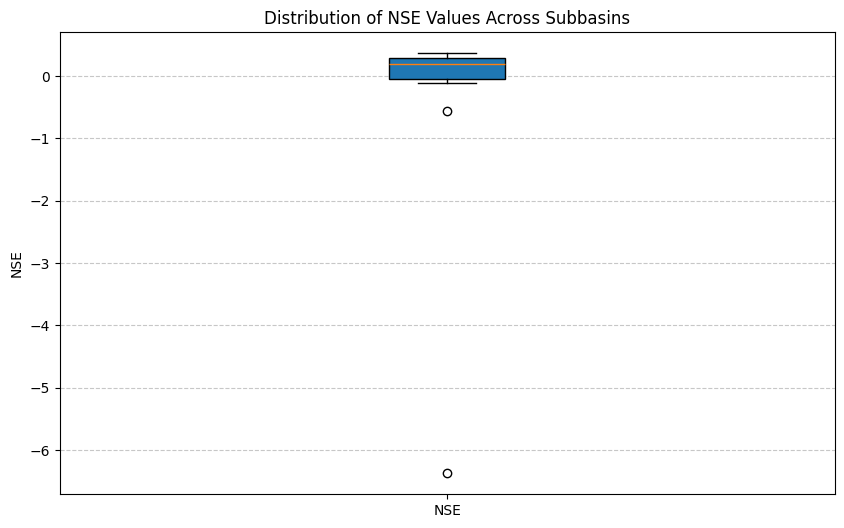

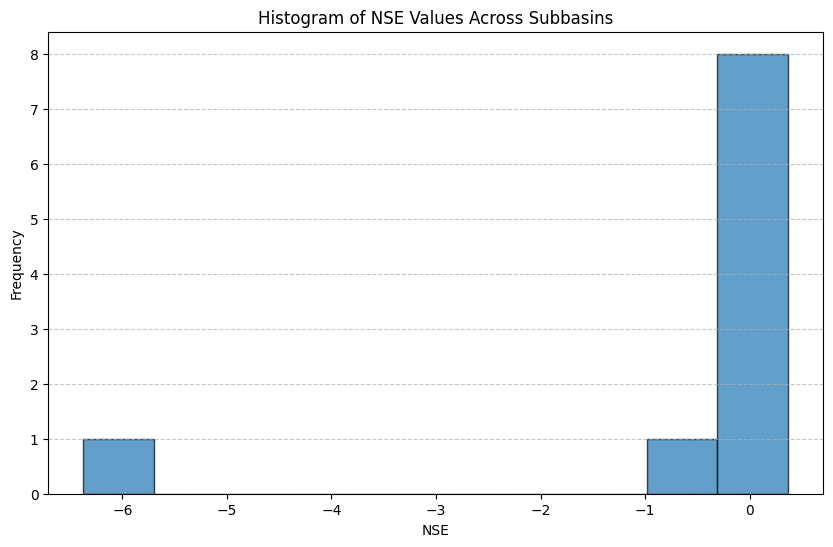

In [11]:

# Plot: Box plot
plt.figure(figsize=(10, 6))
plt.boxplot(nse_df['NSE'], vert=True, patch_artist=True, labels=['NSE'])
plt.title("Distribution of NSE Values Across Subbasins")
plt.ylabel("NSE")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot: Histogram
plt.figure(figsize=(10, 6))
plt.hist(nse_df['NSE'], bins=10, edgecolor='black', alpha=0.7)
plt.title("Histogram of NSE Values Across Subbasins")
plt.xlabel("NSE")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()